In [1]:
import hf_hydrodata as hf
import numpy as np

#q = - K * G * h
#X: (h2 - h1)/(x2-x1),(h_top - h_bot)/(y2-y1) 

layer_number = -10#np.arange(0, 10, 1)#np.array([0:9:1]) #[-1 being the top layer]

# FOR CONUS2
#pressure head
start_time = "2003-01-01 01:00:00"
end_time = "2003-01-01 02:00:00"
options = {"dataset": "conus2_baseline", "variable": "pressure_head",
            "start_time" : start_time,
            "end_time" : end_time,
            #"grid_bounds": ij_bounds
            }

def main(start_time,end_time,options):
    ## Produced from https://hydro-dev.princeton.edu
    
    #Pressure has a format time, z, x,y going from low to high
    press_np = hf.get_gridded_data(options)
    print(press_np.shape)

    ##Constant variables throughout the simulation
    # permeability_x,y,z exists for conus2, but not conus1
    options = {"dataset": "conus2_domain", "variable": "permeability_x"}#
    perm_x = hf.get_gridded_data(options)
    print(perm_x.shape)
    options = {"dataset": "conus2_domain", "variable": "permeability_y"}#
    perm_y = hf.get_gridded_data(options)
    print(perm_y.shape)
    options = {"dataset": "conus2_domain", "variable": "permeability_z"}#
    perm_z = hf.get_gridded_data(options)
    print(perm_z.shape)
    options = {"dataset": "conus2_domain", "variable": "slope_x"}#
    slope_x = hf.get_gridded_data(options)
    print(slope_x.shape)
    options = {"dataset": "conus2_domain", "variable": "slope_y"}#
    slope_y = hf.get_gridded_data(options)
    print(slope_y.shape)
    options = {"dataset": "conus2_domain", "variable": "porosity"}#
    porosity = hf.get_gridded_data(options)
    print(porosity.shape)
    #Max and minimum saturations
    options = {"dataset": "conus2_domain", "variable": "ssat"}#
    ssat = hf.get_gridded_data(options)
    print(ssat.shape)
    options = {"dataset": "conus2_domain", "variable": "sres"}#
    sres = hf.get_gridded_data(options)
    print(sres.shape)
    options = {"dataset": "conus2_domain", "variable": "vg_alpha"}#
    vg_alpha = hf.get_gridded_data(options)
    print(vg_alpha.shape)
    options = {"dataset": "conus2_domain", "variable": "vg_n"}#
    vg_n = hf.get_gridded_data(options)
    print(vg_n.shape)
    
    Delta_x = 1000 #1 km grid size in x direction
    Delta_y = 1000 #1 km grid size in y direction
    Delta_z = [200, 100, 50, 25, 10, 5, 1, 0.6, 0.3, 0.1] #cell thickness in vertical direction from bottom to top [m]
    return press_np,perm_x,perm_y,perm_z,slope_x,slope_y,porosity,Delta_x,Delta_y,Delta_z,ssat,sres,vg_alpha,vg_n

press_np,perm_x,perm_y,perm_z,slope_x,slope_y,porosity,Delta_x,Delta_y,Delta_z,ssat,sres,vg_alpha,vg_n = main(start_time,end_time,options)
    #hf.get_path

(1, 10, 3256, 4442)
(10, 3256, 4442)
(10, 3256, 4442)
(10, 3256, 4442)
(3256, 4442)
(3256, 4442)
(10, 3256, 4442)
(10, 3256, 4442)
(10, 3256, 4442)
(10, 3256, 4442)
(10, 3256, 4442)


In [2]:
#calculate saturation and relative permeability using Van Genuchten model
#Saturation
sw_vG= lambda h,n: (ssat - sres)/((1 + np.abs(vg_alpha*h)**n)**(1-1/n))+sres #sw, head in cms
#Relative permeability
kr_vG= lambda h,n: (1-(np.abs(vg_alpha*h)**(n-1))/(1+np.abs(vg_alpha*h)**n)**(1-1/n))**2.0/((1 + np.abs(vg_alpha*h)**n)**((1-1/n)/2)) #kr

In [3]:
#Calculating saturation and relative permeability at all times since they vary
sat      = sw_vG(press_np,np.kron(np.ones(((np.shape(press_np)[0]),1,1,1)),vg_n))
rel_perm = kr_vG(press_np,np.kron(np.ones(((np.shape(press_np)[0]),1,1,1)),vg_n))
#print(np.shape(np.kron(np.ones(((np.shape(press_np)[0]),1,1,1)),vg_n)))
#key argument np.kron(np.ones(((np.shape(press_np)[0]),1,1,1)),vg_n) where vg_n is the static value

/tmp/ipykernel_1581655/11204392.py:3: RuntimeWarning: divide by zero encountered in divide
  sw_vG= lambda h,n: (ssat - sres)/((1 + np.abs(vg_alpha*h)**n)**(1-1/n))+sres #sw, head in cms
/tmp/ipykernel_1581655/11204392.py:3: RuntimeWarning: invalid value encountered in divide
  sw_vG= lambda h,n: (ssat - sres)/((1 + np.abs(vg_alpha*h)**n)**(1-1/n))+sres #sw, head in cms
/tmp/ipykernel_1581655/11204392.py:5: RuntimeWarning: divide by zero encountered in power
  kr_vG= lambda h,n: (1-(np.abs(vg_alpha*h)**(n-1))/(1+np.abs(vg_alpha*h)**n)**(1-1/n))**2.0/((1 + np.abs(vg_alpha*h)**n)**((1-1/n)/2)) #kr
/tmp/ipykernel_1581655/11204392.py:5: RuntimeWarning: divide by zero encountered in divide
  kr_vG= lambda h,n: (1-(np.abs(vg_alpha*h)**(n-1))/(1+np.abs(vg_alpha*h)**n)**(1-1/n))**2.0/((1 + np.abs(vg_alpha*h)**n)**((1-1/n)/2)) #kr


In [4]:
#Calculating hydraulic conductivities [m/s]
#Assuming absolute permeabilities are in m^2
Delta_rho = 1; grav = 1; mu_w = 1 #Pa.s  #all set to unity because permeability is the saturated hydraulic conductivity
K_x = Delta_rho*grav/mu_w*np.kron(np.ones(((np.shape(press_np)[0]),1,1,1)),perm_x)* rel_perm #Hydraulic conductivity in x direction [m/h]
K_y = Delta_rho*grav/mu_w*np.kron(np.ones(((np.shape(press_np)[0]),1,1,1)),perm_y)* rel_perm #Hydraulic conductivity in y direction [m/h]
K_z = Delta_rho*grav/mu_w*np.kron(np.ones(((np.shape(press_np)[0]),1,1,1)),perm_z)* rel_perm #Hydraulic conductivity in z direction [m/h]

/tmp/ipykernel_1581655/3836467104.py:4: RuntimeWarning: invalid value encountered in multiply
  K_x = Delta_rho*grav/mu_w*np.kron(np.ones(((np.shape(press_np)[0]),1,1,1)),perm_x)* rel_perm #Hydraulic conductivity in x direction [m/h]
/tmp/ipykernel_1581655/3836467104.py:5: RuntimeWarning: invalid value encountered in multiply
  K_y = Delta_rho*grav/mu_w*np.kron(np.ones(((np.shape(press_np)[0]),1,1,1)),perm_y)* rel_perm #Hydraulic conductivity in y direction [m/h]
/tmp/ipykernel_1581655/3836467104.py:6: RuntimeWarning: invalid value encountered in multiply
  K_z = Delta_rho*grav/mu_w*np.kron(np.ones(((np.shape(press_np)[0]),1,1,1)),perm_z)* rel_perm #Hydraulic conductivity in z direction [m/h]


In [5]:
#Calculating gradients of pressure head using np.gradient
import gc
import time
time_iter = 0
head_one_time = press_np[time_iter,:,:,:] #pressure head at a single time
sat_one_time = sat[time_iter,:,:,:]       #saturation at a single time

#Deleting to free up the memory
press_np = None
sat = None
perm_x = None
perm_y = None
perm_z = None
ssat = None
sres = None
vg_alpha = None
vg_n = None
rel_perm = None

gc.collect()
time.sleep(10)

dhbydz,dhbydx,dhbydy = np.gradient(head_one_time, Delta_z,Delta_x,Delta_y)
print(np.shape(head_one_time))
print(np.shape(dhbydz),np.shape(dhbydx),np.shape(dhbydy))

(10, 3256, 4442)
(10, 3256, 4442) (10, 3256, 4442) (10, 3256, 4442)


In [6]:
#Calculate slope angles
theta_x = np.arctan(slope_x)
theta_y = np.arctan(slope_y)

#Deleting to free up the memory
slope_x = None
slope_y = None

gc.collect()
time.sleep(10)


In [7]:
#Calculate Darcy's flux in terrain-following coordinates
q_xprime = -K_x[time_iter,:,:,:] * (dhbydx * np.cos(theta_x) + np.sin(theta_x)) #Darcy flux in vertical direction [m/h]
q_yprime = -K_y[time_iter,:,:,:] * (dhbydy * np.cos(theta_y) + np.sin(theta_y)) #Darcy flux in x direction [m/h]
q_zprime = -K_z[time_iter,:,:,:] * dhbydz #Darcy flux in y direction [m/h]

#Deleting to free up the memory
dhbydx = None
dhbydy = None
dhbydz = None
K_x = None
K_y = None
K_z = None

gc.collect()
time.sleep(10)

In [8]:
# FOR CONUS2
#pressure head
start_time = "2003-05-01 01:00:00"
end_time = "2003-05-01 02:00:00"
options = {"dataset": "conus2_baseline", "variable": "pressure_head",
            "start_time" : start_time,
            "end_time" : end_time,
            #"grid_bounds": ij_bounds
            }

def main_indicator(start_time,end_time,options):
    
    ##Constant variables throughout the simulation
    # permeability_x,y,z exists for conus2, but not conus1
    options = {"dataset": "conus2_domain", "variable": "pf_flowbarrier"}#
    pf_flowbarrier = hf.get_gridded_data(options)
    print(pf_flowbarrier.shape)
    options = {"dataset": "conus2_domain", "variable": "pf_indicator"}#
    pf_indicator = hf.get_gridded_data(options)
    print(pf_indicator.shape)
    return pf_flowbarrier, pf_indicator

pf_flowbarrier, pf_indicator = main_indicator(start_time,end_time,options)

#changing the flow barrier only in z direction
q_zprime = q_zprime*pf_flowbarrier


#flow barrier value is 1.0 and 0.001
import gc
import time
np.min(pf_flowbarrier[pf_flowbarrier>0.001])
pf_indicator   = None
pf_flowbarrier = None
gc.collect()
time.sleep(10)

(10, 3256, 4442)
(10, 3256, 4442)


In [9]:
#Align properly with gravity in this step (currently with terrain-following grid coordinates)
#Maybe include the effect of gravity, need to cross check
#realigning the fluxes with the physical coordinates
q_x      = q_xprime * np.cos(theta_x)
q_y      = q_yprime * np.cos(theta_y)
q_z      = q_zprime + q_xprime * np.sin(theta_x) + q_yprime * np.sin(theta_y)

#Deleting to free up the memory
theta_x = None
theta_y = None
q_xprime= None
q_yprime= None
q_zprime= None

gc.collect()
time.sleep(10)

In [10]:
def main_new(start_time,end_time,options):
    #Pressure has a format time, z, x,y going from low to high
    press_np = hf.get_gridded_data(options)
    print(press_np.shape)

    ##Constant variables throughout the simulation
    options = {"dataset": "conus2_domain", "variable": "specific_storage"}#
    specific_storage = hf.get_gridded_data(options)
    print(specific_storage.shape)
    
    return specific_storage

specific_storage = main_new(start_time,end_time,options)

(1, 10, 3256, 4442)
(10, 3256, 4442)


In [11]:
#Calculate the total volume and the US-equivalent layer
#Calculate new porosity for a single value of head at one instant
pos_head_one_time = head_one_time.copy(); pos_head_one_time[pos_head_one_time>0] = 0.0 #removing unsaturated zone for the decompaction
porosity = porosity + pos_head_one_time * specific_storage #initial porosity + decompaction due to higher water pressure causing ice decompaction

s_unsat = sat_one_time.copy(); 
print(np.argwhere(head_one_time<0))
s_unsat[head_one_time<0]= np.nan #saturated regions are masked now with no water
#s_unsat[pf_flowbarrier==0.001] = np.nan #flow barriers masked now with no water
s_sat   = sat_one_time.copy(); s_sat[head_one_time>=0]= np.nan   #unsaturated regions are masked now with no water
#s_sat[pf_flowbarrier==0.001] = np.nan #flow barriers masked now with no water

pf_flowbarrier = None
gc.collect()
time.sleep(10)

print(np.shape(s_unsat)); print(np.shape(s_sat))

#Find total volume of water in unsaturated region [m^3]
#x and y directions are easy so we can just sum in those directions, for z we need to multiply with a matrix
Volume_tot_unsat = Delta_x*Delta_y*np.sum(np.sum(porosity*np.nan_to_num(s_unsat, nan=0.0),axis=1),axis=1) #summing in x and y directions with multiplication of (porosity+specific_storage*head_one_time) and Delta x and Delta 
Volume_tot_unsat = np.sum(Delta_z*Volume_tot_unsat)   #summing in z directions by scaling with Delta z
print('The total volume of water in unsaturated zone is',Volume_tot_unsat/1e9,'km^3')

#Find total water in the saturated regions [m^3]
#x and y directions are easy so we can just sum in those directions, for z we need to multiply with a matrix
Volume_tot_sat = Delta_x*Delta_y*np.sum(np.sum(porosity*np.nan_to_num(s_sat, nan=0.0),axis=1),axis=1) #summing in x and y directions with multiplication of porosity and Delta x and Delta 
Volume_tot_sat = np.sum(Delta_z*Volume_tot_sat)   #summing in z directions by scaling with Delta z
print('The total volume of water in saturated region is',Volume_tot_sat/1e9,'km^3')

#Area of the United States is 
Area_US = 9840000  #km^2 source: https://www.britannica.com/topic/largest-U-S-state-by-area
GEL_unsat = Volume_tot_unsat/(Area_US*1e6)
GEL_sat = Volume_tot_sat/(Area_US*1e6)
print('The US equivalent layer of water in unsaturated zone is',GEL_unsat,'m.')
print('The US equivalent layer of water in saturated zone is',GEL_sat,'m.')

#Deleting to free up the memory
GEL_unsat = None
GEL_sat = None
Volume_tot_sat= None
Volume_tot_unsat= None
Volume_tot_unsat= None
specific_storage= None
pos_head_one_time=None

gc.collect()
time.sleep(10)

[[   0    0    0]
 [   0    0    1]
 [   0    0    2]
 ...
 [   9 3255 4439]
 [   9 3255 4440]
 [   9 3255 4441]]
(10, 3256, 4442)
(10, 3256, 4442)
The total volume of water in unsaturated zone is 6510.10043474681 km^3
The total volume of water in saturated region is 10345.04035995443 km^3
The US equivalent layer of water in unsaturated zone is 0.6615955726368709 m.
The US equivalent layer of water in saturated zone is 1.0513252398327673 m.


In [12]:
#Calculate resultant Darcy flux (currently in terrain following grid)
q_T = np.sqrt(q_x**2+q_y**2+q_z**2) #resultant total flux of water [m/h]
q_L = np.sqrt(q_x**2+q_y**2)        #resultant lateral flow of water [m/h]


#Make a volume array for the grid in m^3
Volume = np.kron(np.ones((1,np.shape(head_one_time)[1],np.shape(head_one_time)[2])),np.transpose([[Delta_z]]))*Delta_x*Delta_y#np.kron(np.ones(((np.shape(press_np)[0]),1,1),Delta_x)

# #Ratio of lateral velocity
# Ratio = q_L/q_T
# Ratio*porosity*Delta_x*Delta*y

print(np.shape(Volume))

q_T[head_one_time<0]= np.nan #saturated regions are masked now with no water
q_L[head_one_time<0]= np.nan #saturated regions are masked now with no water

lateral_flow_percentage_without_vol = (q_L/q_T)[layer_number,:,:]*100
lateral_flow_percentage_with_vol    = (q_L/q_T*Volume*porosity*s_unsat)[layer_number,:,:]/np.nanmax((Volume*porosity*s_unsat)[layer_number,:,:])*100

print('Sanity check for volume in unsaturated region',np.sum(Volume*porosity*np.nan_to_num(s_unsat, nan=0.0))/1e9,'km^3')
print('Sanity check for volume in saturated region',np.sum(Volume*porosity*np.nan_to_num(s_sat, nan=0.0))/1e9,'km^3')
print(lateral_flow_percentage_with_vol[~np.isnan(lateral_flow_percentage_with_vol)])
print(lateral_flow_percentage_without_vol[~np.isnan(lateral_flow_percentage_without_vol)])

(10, 3256, 4442)
Sanity check for volume in unsaturated region 6510.100434746841 km^3
Sanity check for volume in saturated region 10345.040359954388 km^3
[ 0.2020181   0.05484797  0.04624841 ... 10.83520573  2.72701447
  0.42820434]
[99.73524736 99.93932922 99.78689048 ... 99.82048455 99.65731953
 99.71538627]


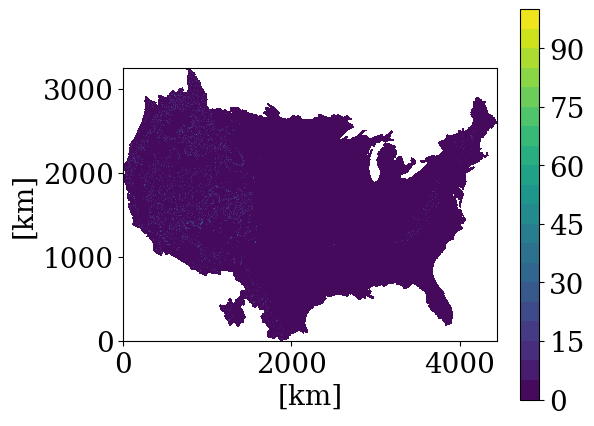

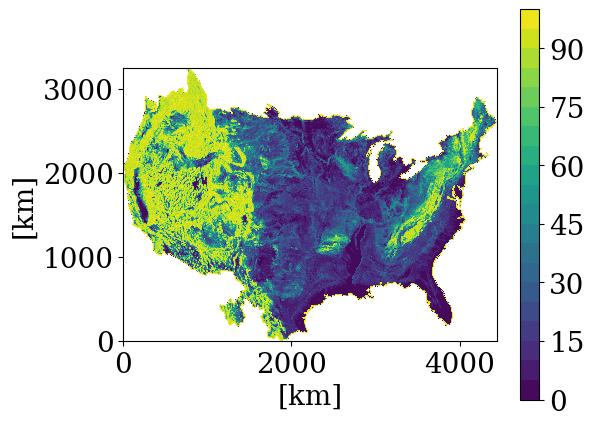

In [13]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as animation
from matplotlib.ticker import LinearLocator, FormatStrFormatter
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'font.family': 'Serif'})

# Define the levels explicitly from 0 to 100 (e.g., in steps of 5)
levels = np.linspace(0, 100, 21)  # 21 levels → 0, 5, 10, ..., 100
plt.figure()
contour = plt.contourf(lateral_flow_percentage_with_vol, cmap='viridis', vmin=0, vmax=100, levels=levels)
plt.colorbar(contour)
plt.xlabel('[km]')
plt.ylabel('[km]')
# Get current axis and set aspect ratio to equal
ax = plt.gca()
ax.set_aspect('equal')
plt.tight_layout()
plt.savefig(f'map_occurences_with_vol_layerno_{layer_number}.pdf', bbox_inches='tight', dpi=50)

levels = np.linspace(0, 100, 21)  # 21 levels → 0, 5, 10, ..., 100
plt.figure()
contour = plt.contourf(lateral_flow_percentage_without_vol, cmap='viridis', vmin=0, vmax=100, levels=levels)
plt.colorbar(contour)
plt.xlabel('[km]')
plt.ylabel('[km]')
# Get current axis and set aspect ratio to equal
ax = plt.gca()
ax.set_aspect('equal')
plt.tight_layout()
plt.savefig(f'map_occurences_without_vol_layerno_{layer_number}.pdf', bbox_inches='tight', dpi=50)


[nan nan nan ... nan nan nan]
[99.73524736 99.93932922 99.78689048 ... 99.82048455 99.65731953
 99.71538627]


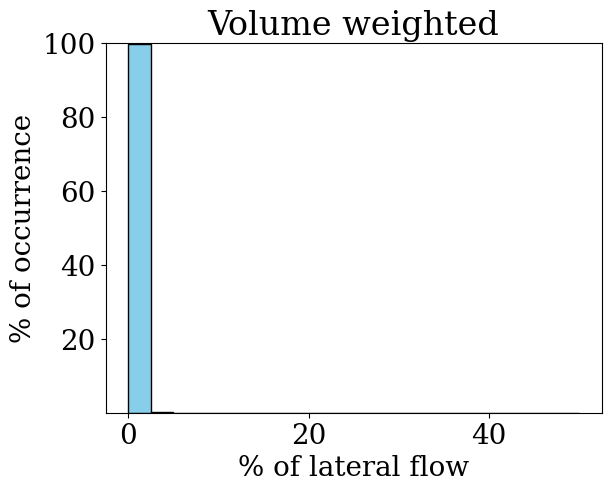

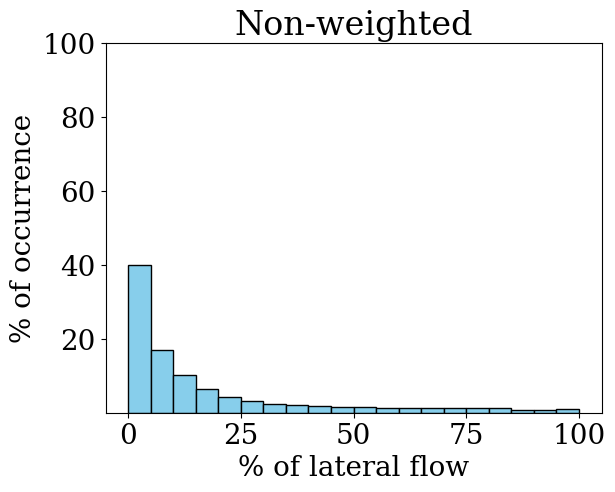

In [14]:
#with direct effect of volume
plt.figure()
plt.title('Volume weighted')
lateral_flow_percentage_with_vol = np.ravel(lateral_flow_percentage_with_vol)
data_with_vol = lateral_flow_percentage_with_vol[~np.isnan(lateral_flow_percentage_with_vol)]
plt.hist(data_with_vol,bins=20, color = "skyblue", ec="black", weights=100*np.ones_like(data_with_vol) / len(data_with_vol))
np.shape(np.log(np.ravel(lateral_flow_percentage_with_vol)))
print(np.ravel(lateral_flow_percentage_with_vol))
#plt.xscale('log')
#plt.yscale('log')
#plt.yticks([1e-4,1e-2,1e-0,1e2])
plt.ylim([1e-4,1e2])
#plt.xlim([1e-6,1e2])
plt.ylabel('% of occurrence')
plt.xlabel('% of lateral flow')
plt.savefig(f'occurences_with_vol_layerno_{layer_number}.pdf',bbox_inches='tight', dpi = 50)

#without effect of volume
plt.figure()
plt.title('Non-weighted')
lateral_flow_percentage_without_vol = np.ravel(lateral_flow_percentage_without_vol)
data_without_vol = lateral_flow_percentage_without_vol[~np.isnan(lateral_flow_percentage_without_vol)]
plt.hist(data_without_vol,bins=20, color = "skyblue", ec="black", weights=100*np.ones_like(data_without_vol) / len(data_without_vol))
np.shape(np.log(np.ravel(lateral_flow_percentage_without_vol)))
#plt.xscale('log')
#plt.yscale('log')
#plt.xticks([1e-6,1e-4,1e-2,1e-0,1e2])
#plt.xlim([1e-6,1e2])
plt.ylim([1e-4,1e2])
#plt.yticks([1e-4,1e-2,1e-0,1e2])
plt.ylabel('% of occurrence')
plt.xlabel('% of lateral flow')
plt.savefig(f'occurences_without_vol_layerno_{layer_number}.pdf',bbox_inches='tight', dpi = 50)


#without effect of volume
print(np.ravel(data_without_vol))

#Deleting to free up the memory
lateral_flow_percentage_without_vol = None
data_without_vol = None
data_with_vol = None

gc.collect()
time.sleep(10)